# $D^0 \to K^0_Sπ^+π^-$ with Mixing

We will fit 

$$
D^0 \to K^0_S \pi^+\pi^-
$$

decays generated with the following intermediate resonances:
- $D^0 \to K^0_S \rho(770)$
- $D^0 \to K^{*-}\pi^+$

In addition we add mixing, meaning that $D^0$ oscillates to $\bar{D}^0$, which subsequently decays with a charged-conjugate decay model, depending on time:

$$
|\mathcal{A}(t)|^2 = \frac{1}{4}\left|\mathcal{A}_{D^0} + \frac{q}{p}\mathcal{A}_{\bar{D}^0}\right|^2 \psi_+(t) + 
                     \frac{1}{4}\left|\mathcal{A}_{D^0} - \frac{q}{p}\mathcal{A}_{\bar{D}^0}\right|^2 \psi_-(t) + 
                     2 \Re{\left((\mathcal{A}_{D^0} + \frac{q}{p}\mathcal{A}_{\bar{D}^0})(\mathcal{A}_{D^0} - \frac{q}{p}\mathcal{A}_{\bar{D}^0})^*\right)}\psi_i(t),
$$

with

$$
\begin{align*}
\psi_+(t) &= e^{ -(1-x)\frac{t}{\tau} }\\
\psi_-(t) &= e^{ -(1+x)\frac{t}{\tau} }\\
\psi_i(t) &= e^{ -(1-iy)\frac{t}{\tau} }\\
\end{align*}
$$

Import modules

In [1]:
# import NumPy
import numpy as np
# Import Tensorflow
import tensorflow as tf
# Import AmpliTF modules
import amplitf.interface as atfi
import amplitf.kinematics as atfk
import amplitf.dynamics as atfd
import amplitf.likelihood as atfl
from amplitf.phasespace.dalitz_phasespace import DalitzPhaseSpace
from amplitf.phasespace.decaytime_phasespace import DecayTimePhaseSpace
from amplitf.phasespace.combined_phasespace import CombinedPhaseSpace
from amplitf.mixing import Mixing

# Import TFA modules
import tfa.toymc as tft
import tfa.plotting as tfp
import tfa.optimisation as tfo

# Import plotting module
import matplotlib.pyplot as plt

2024-10-21 16:56:02.736255: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-21 16:56:02.749231: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-21 16:56:02.767049: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-21 16:56:02.767070: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-21 16:56:02.778217: I tensorflow/core/platform/cpu_feature_gua

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


Set the number of events to generate and the number of normalisation point to calculate the integral of the likelihood

In [2]:
ntoys = 100000  # Number of points to generate
nnorm = 1000000  # Number of normalisation points

Now define some constants

In [3]:
# Masses of final state particles
from particle.particle import literals as lp
# Dalitz Particles
mkz = atfi.const(lp.K_S_0.mass/1000)
mpi = atfi.const(lp.pi_plus.mass/1000)
md = atfi.const(lp.D_0.mass/1000)

# Resonances
mkst = atfi.const(lp.Kst_892_0.mass/1000)
wkst = atfi.const(lp.Kst_892_0.width/1000)
mrho = atfi.const(lp.rho_770_0.mass/1000)
wrho = atfi.const(lp.rho_770_0.width/1000)

# Blatt-Weisskopf radii for Breit-Wigner lineshape
rd = atfi.const(5.0)
rr = atfi.const(1.5)

2024-10-21 16:56:06.642755: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79196 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:b1:00.0, compute capability: 8.0


The mixing parameters

In [21]:
tdz = atfi.const(1.)
x_mix = atfi.const(0.004)
y_mix = atfi.const(0.0064)
qop_mix = atfi.const(1)
phi_mix = atfi.const(0)
qoverp = atfi.complex( qop_mix * atfi.cos(phi_mix), 
                       qop_mix * atfi.sin(phi_mix) )

and a class to deal with three-body Dalitz phase-space

In [5]:
phsp = DalitzPhaseSpace(mpi, mkz, mpi, md)

Add a class to deal with the decay time

In [6]:
tphsp = DecayTimePhaseSpace(tdz)

And the combined phase-space

In [7]:
c_phsp = CombinedPhaseSpace(phsp,tphsp)

## Phasespace
Let's study the phasespace and the value of the functions on it

In [8]:
comb_sample = c_phsp.filter(c_phsp.unfiltered_sample(10000,1.0e-20))

Plot the invariant masses and the decay time

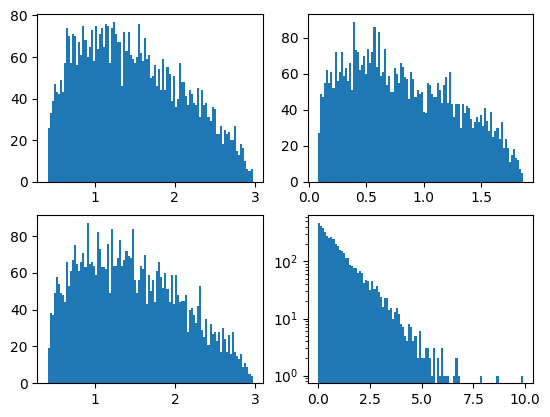

In [9]:
fig, ax = plt.subplots(2,2)
_ = ax[0][0].hist( np.array(c_phsp.phsp1.m2ab(c_phsp.data1(comb_sample)) ),bins=100)
_ = ax[1][0].hist( np.array(c_phsp.phsp1.m2bc(c_phsp.data1(comb_sample)) ),bins=100)
_ = ax[0][1].hist( np.array(c_phsp.phsp1.m2ac(c_phsp.data1(comb_sample)) ),bins=100)
_ = ax[1][1].hist( np.array(c_phsp.phsp2.t(c_phsp.data2(comb_sample)) ),bins=100)
ax[1][1].set_yscale('log')

## Model
Below there is a function to define the model, allowing to switch on and off specific components.

In [10]:
def model(x):

    m2ab = phsp.m2ab(x)
    m2bc = phsp.m2bc(x)
    m2ac = phsp.m2ac(x)

    hel_ab = atfd.helicity_amplitude(phsp.cos_helicity_ab(x), 1)
    hel_bc = atfd.helicity_amplitude(phsp.cos_helicity_bc(x), 1)
    hel_ac = atfd.helicity_amplitude(phsp.cos_helicity_ac(x), 1)

    bw1 = atfd.breit_wigner_lineshape(m2ab, mkst, wkst, mpi, mkz, mpi, md, rd, rr, 1, 1)
    bw2 = atfd.breit_wigner_lineshape(m2bc, mkst, wkst, mpi, mkz, mpi, md, rd, rr, 1, 1)
    bw3 = atfd.breit_wigner_lineshape(m2ac, mrho, wrho, mpi, mpi, mkz, md, rd, rr, 1, 1)

    def _model(a1r, a1i, a2r, a2i, a3r, a3i, switches=4 * [1]):

        a1 = atfi.complex(a1r, a1i)
        a2 = atfi.complex(a2r, a2i)
        a3 = atfi.complex(a3r, a3i)

        ampl = atfi.cast_complex(atfi.ones(m2ab)) * atfi.complex(
            atfi.const(0.0), atfi.const(0.0)
        )

        if switches[0]:
            ampl += a1 * bw1 * hel_ab
        if switches[1]:
            ampl += a2 * bw2 * hel_bc
        if switches[2]:
            ampl += a3 * bw3 * hel_ac
        if switches[3]:
            ampl += atfi.cast_complex(atfi.ones(m2ab)) * atfi.complex(
                atfi.const(5.0), atfi.const(0.0)
            )

        return atfd.density(ampl)

    return _model

In [11]:
# Time evolution functions.
@atfi.function
def psip( t, x, tau ):
    """Time evolution function $\psi_+(t)$

    Args:
        t (float): decay time of the candidate
        x (float): mixing parameter
        tau (float): lifetime of the decaying particle

    Returns:
        float: the time evolution function for the sum of the two decay amplitudes
    """
    return atfi.exp( - ( 1.0 - x ) * t / tau)

@atfi.function
def psim( t, x, tau ):
    """Time evolution function $\psi_-(t)$

    Args:
        t (float): decay time of the candidate
        x (float): mixing parameter
        tau (float): lifetime of the decaying particle

    Returns:
        float: the time evolution function for the sum of the two decay amplitudes
    """
    return atfi.exp( - ( 1.0 + x ) * t / tau)

@atfi.function
def psii( t, y, tau ):
    """Time evolution function $\psi_i(t)$

    Args:
        t (float): decay time of the candidate
        y (float): mixing parameter
        tau (float): lifetime of the decaying particle

    Returns:
        float: the time evolution function for the sum of the two decay amplitudes
    """
    return atfi.exp( - atfi.complex( atfi.const(1.0) , -y ) * tf.cast(t / tau, tf.complex128))

In [12]:
def model_mix(x):

    # DZ - MIXING MODEL
    
    # CACHED VARIABLES
    m2ab = c_phsp.phsp1.m2ab(x)
    m2bc = c_phsp.phsp1.m2bc(x)
    m2ac = c_phsp.phsp1.m2ac(x)

    hel_ab = atfd.helicity_amplitude(c_phsp.phsp1.cos_helicity_ab(x), 1)
    hel_bc = atfd.helicity_amplitude(c_phsp.phsp1.cos_helicity_bc(x), 1)
    hel_ac = atfd.helicity_amplitude(c_phsp.phsp1.cos_helicity_ac(x), 1)

    bw1 = atfd.breit_wigner_lineshape(m2ab, mkst, wkst, mpi, mkz, mpi, md, rd, rr, 1, 1)
    bw2 = atfd.breit_wigner_lineshape(m2bc, mkst, wkst, mpi, mkz, mpi, md, rd, rr, 1, 1)
    bw3 = atfd.breit_wigner_lineshape(m2ac, mrho, wrho, mpi, mpi, mkz, md, rd, rr, 1, 1)

    tep = psip(c_phsp.phsp2.t(c_phsp.data2(x)), x_mix, tdz)
    tem = psim(c_phsp.phsp2.t(c_phsp.data2(x)), x_mix, tdz)
    tei = psii(c_phsp.phsp2.t(c_phsp.data2(x)), y_mix, tdz)

    def _model(a1r, a1i, a2r, a2i, a3r, a3i, switches=4 * [1]):

        a1 = atfi.complex(a1r, a1i)
        a2 = atfi.complex(a2r, a2i)
        a3 = atfi.complex(a3r, a3i)

        # D0 AMPLITUDE
        ampl_dz = atfi.cast_complex(atfi.ones(m2ab)) * atfi.complex(
            atfi.const(0.0), atfi.const(0.0)
        )

        if switches[0]:
            ampl_dz += a1 * bw1 * hel_ab
        if switches[1]:
            ampl_dz += a2 * bw2 * hel_bc
        if switches[2]:
            ampl_dz += a3 * bw3 * hel_ac
        if switches[3]:
            ampl_dz += atfi.cast_complex(atfi.ones(m2ab)) * atfi.complex(
                atfi.const(5.0), atfi.const(0.0)
            )

        # D0bar AMPLITUDE: exchange a <--> c
        ampl_dzb = atfi.cast_complex(atfi.ones(m2ab)) * atfi.complex(
            atfi.const(0.0), atfi.const(0.0)
        )

        if switches[0]:
            ampl_dzb += a1 * bw2 * hel_bc
        if switches[1]:
            ampl_dzb += a2 * bw1 * hel_ab
        if switches[2]:
            ampl_dzb += -a3 * bw3 * hel_ac
        if switches[3]:
            ampl_dzb += atfi.cast_complex(atfi.ones(m2ab)) * atfi.complex(
                atfi.const(5.0), atfi.const(0.0)
            )

        # MIXING
        ampl = atfi.cast_complex(atfi.ones(m2ab)) * atfi.complex(
            atfi.const(0.0), atfi.const(0.0) )
        ampDir = ampl_dz
        ampCnj = qoverp * ampl_dzb

        apb2 = 0.5 * (ampDir + ampCnj)
        amb2 = 0.5 * atfi.conjugate(ampDir - ampCnj)
        dens = atfd.density( tf.multiply(apb2 , atfi.complex(tep, atfi.const(0)) ) )
        # mix_model = Mixing(ampl_dz, ampl_dzb, tdz, 
        #                    x_mix, y_mix, qop_mix, phi_mix)
        # ampl = mix_model.amplitude(c_phsp.phsp2.t(x))
        
        return atfd.density( dens )

    return _model

**TODO**: The syntax above does not work for the mixing class I though because it multiplies at a certain point a function to a tensor.
I should try to define a full model with mixing as a function and then think how this can be generalised in the code.

## Toy MC Model
The model of the toy MC has all the components on by default. By means of the `switches` flag, some of them can be turned off to see the effects on the fit.

In [13]:
def toymc_model(x, switches=4 * [1]):
    return model_mix(x)(
        switches=switches,
        a1r=atfi.const(1.0),
        a1i=atfi.const(0.0),
        a2r=atfi.const(0.5),
        a2i=atfi.const(0.0),
        a3r=atfi.const(2.0),
        a3i=atfi.const(0.0),
    )

In [14]:
toy = toymc_model(comb_sample)

In [15]:
tep = psip(c_phsp.phsp2.t(c_phsp.data2(comb_sample)), x_mix, tdz)
print(tep)

tf.Tensor(
[[0.68958815]
 [0.65933642]
 [0.4791328 ]
 ...
 [0.29983519]
 [0.90755347]
 [0.55306431]], shape=(4806, 1), dtype=float64)


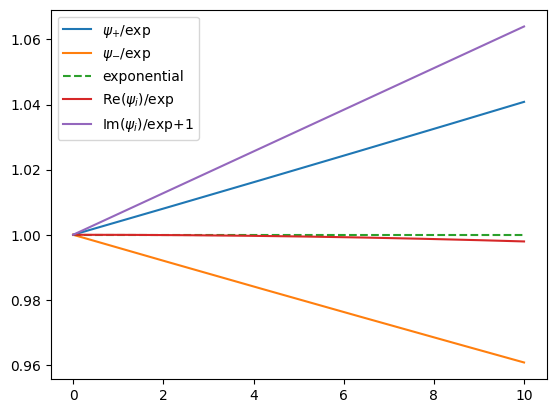

In [33]:
t_pl = np.linspace(0,10,1000)
plt.plot( t_pl, psip(t_pl, x_mix, tdz)/np.exp(-t_pl/tdz), label=r'$\psi_{+}$/exp' )
plt.plot( t_pl, psim(t_pl, x_mix, tdz)/np.exp(-t_pl/tdz), label=r'$\psi_{-}$/exp' )
plt.plot( t_pl, np.ones(len(t_pl)), label='exponential', linestyle='dashed' )
plt.plot( t_pl, np.real(psii(t_pl, y_mix, tdz))/np.exp(-t_pl/tdz), label=r'Re($\psi_{i}$)/exp' )
plt.plot( t_pl, 1+np.imag(psii(t_pl, y_mix, tdz))/np.exp(-t_pl/tdz), label=r'Im($\psi_{i}$)/exp+1' )
#plt.yscale('log')
plt.legend()

## Likelihood

The Negative Log Likelihood

In [34]:
# TF graph for unbinned negalite log likelihood (the quantity to be minimised)
def nll(data, norm):
    data_model = model_mix(data)
    norm_model = model_mix(norm)

    @atfi.function
    def _nll(pars):
        return atfl.unbinned_nll(data_model(**pars), atfl.integral(norm_model(**pars)))

    return _nll

## Samples

The samples to fit

In [35]:
print(comb_sample)

tf.Tensor(
[[1.04691199e+00 2.09825573e+00 3.71660745e-01 9.06997633e-21]
 [1.33135050e+00 1.79476480e+00 4.16521375e-01 2.02658012e-21]
 [8.05834527e-01 1.72644185e+00 7.35777477e-01 5.15068568e-21]
 ...
 [1.53516621e+00 7.61067544e-01 1.20452232e+00 4.83897543e-21]
 [1.05163684e+00 1.57295821e+00 9.70027941e-02 4.78110270e-21]
 [1.55486062e+00 1.04543433e+00 5.92280988e-01 4.15781848e-21]], shape=(4806, 4), dtype=float64)


In [36]:
toy_sample = tft.run_toymc(
    toymc_model, c_phsp, ntoys, maximum=1.0e-20, chunk=1000000, components=False
)

print(toy_sample)

ValueError: in user code:

    File "/user/gr1/lhcb/mmartinelli/dalitz/TFA2/tfa/toymc.py", line 70, in pdf_vals  *
        d = accept_reject_sample(
    File "/user/gr1/lhcb/mmartinelli/dalitz/AmpliTF/amplitf/phasespace/combined_phasespace.py", line 52, in filter
        return tf.boolean_mask(x, self.inside(x))

    ValueError: Number of mask dimensions must be specified, even if some dimensions are None.  E.g. shape=[None] is ok, but shape=None is not.


and to calculate the integrals

In [ ]:
norm_sample = phsp.uniform_sample(nnorm)

print(norm_sample)

Beware that only approximately 1/2 of the events have been generated in the normalisation sample.

## Fit

We are now ready to run the fit. We define first the fit parameters:

In [ ]:
pars = [
    tfo.FitParameter("a1r", 1.0, -10.0, 10.0),
    tfo.FitParameter("a1i", 0.0, -10.0, 10.0),
    tfo.FitParameter("a2r", 0.5, -10.0, 10.0),
    tfo.FitParameter("a2i", 0.0, -10.0, 10.0),
    tfo.FitParameter("a3r", 2.0, -10.0, 10.0),
    tfo.FitParameter("a3i", 0.0, -10.0, 10.0),
]

and run Minuit

In [ ]:
# Run MINUIT minimisation of the neg. log likelihood
result = tfo.run_minuit(nll(toy_sample, norm_sample), pars)
print(result)
cov = result['covariance']

print(f"{result['time']/result['func_calls']} sec per function call")

fitted_pars = {p: atfi.const(v[0]) for p, v in result["params"].items()}

Define a function with the fitted model to calculate fit fractions and projections

In [ ]:
def fitted_model(x, switches=4 * [1]):
    return model(x)(**fitted_pars, switches=switches)

The fit fractions are calculated

In [ ]:
ff = tfo.calculate_fit_fractions(fitted_model, norm_sample)
print(ff)

## Plotting

For plotting the results we generate a sample according to the model and we overlay it to the data

In [ ]:
fitted_sample = tft.run_toymc(
    fitted_model, phsp, nnorm, maximum=1.0e-20, chunk=1000000, components=True
)

In [ ]:
# Plot results
import matplotlib.pyplot as plt

tfp.set_lhcb_style(size=12, usetex=False)  # Adjust plotting style for LHCb papers
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))  # Single subplot on the figure

# Plot 1D histogram from the toy MC sample
tfp.plot_distr2d(
    toy_sample[:, 0],
    toy_sample[:, 1],
    bins=(50, 50),
    ranges=((0.3, 3.1), (0.3, 3.1)),
    fig=fig,
    ax=ax[0, 0],
    labels=(r"$m^2(K_S^0\pi^+)$", r"$m^2(K_S^0\pi^-)$"),
    units=("MeV$^2$", "MeV$^2$"),
    log=True,
)

tfp.plot_distr1d_comparison(
    toy_sample[:, 0],
    fitted_sample[:, 0],
    cweights=[fitted_sample[:, 2 + i] for i in range(4)],
    bins=50,
    range=(0.3, 3.1),
    ax=ax[0, 1],
    label=r"$m^2(K_S^0\pi^+)$",
    units="MeV$^2$",
    legend=False
)

tfp.plot_distr1d_comparison(
    toy_sample[:, 1],
    fitted_sample[:, 1],
    cweights=[fitted_sample[:, 2 + i] for i in range(4)],
    bins=50,
    range=(0.3, 3.1),
    ax=ax[1, 0],
    label=r"$m^2(K_S^0\pi^-)$",
    units="MeV$^2$",
    legend=False
)

tfp.plot_distr1d_comparison(
    phsp.m2ac(toy_sample),
    phsp.m2ac(fitted_sample),
    cweights=[fitted_sample[:, 2 + i] for i in range(4)],
    bins=50,
    range=(0.05, 1.9),
    ax=ax[1, 1],
    label=r"$m^2(\pi^+\pi^-)$",
    units="MeV$^2$",
    legend_ax=ax[1,2]
)

# Show the plot
plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)

In [ ]:
tt = c_phsp.filter(c_phsp.unfiltered_sample(1000))

In [ ]:
model_mix(tt)

In [13]:
csm = c_phsp.unfiltered_sample(1000)

In [ ]:
csm

In [ ]:
c_phsp.data1(csm)

In [ ]:
c_phsp.data2(csm)

In [ ]:
c_phsp.phsp1.inside(c_phsp.data1(csm))

In [ ]:
c_phsp.phsp2.inside(c_phsp.data2(csm))

In [14]:
import tensorflow as tf

In [15]:
tf.logical_and(c_phsp.phsp1.inside(c_phsp.data1(csm)), c_phsp.phsp2.inside(c_phsp.data2(csm)))

<tf.Tensor: shape=(1000,), dtype=bool, numpy=
array([False, False,  True, False, False,  True, False,  True, False,
        True, False, False, False, False,  True,  True, False,  True,
       False, False,  True,  True,  True, False, False, False,  True,
       False,  True, False,  True,  True,  True, False,  True,  True,
       False,  True, False,  True, False, False,  True, False,  True,
       False,  True,  True, False, False,  True,  True, False,  True,
        True,  True, False,  True, False, False,  True, False,  True,
        True, False, False, False, False, False, False,  True,  True,
       False, False, False,  True,  True,  True,  True, False, False,
        True, False, False,  True, False, False, False, False,  True,
        True,  True, False,  True, False, False,  True, False, False,
       False, False,  True,  True,  True,  True, False, False,  True,
       False, False,  True, False,  True, False,  True,  True, False,
       False, False,  True, False, False,  T

In [ ]:
c_phsp.inside(csm)

In [16]:
tf.boolean_mask(csm, c_phsp.inside(csm))

<tf.Tensor: shape=(446, 3), dtype=float64, numpy=
array([[1.26845584, 1.40739703, 2.52047777],
       [1.52090891, 1.74615411, 0.08005097],
       [2.79709285, 0.4208446 , 1.32477453],
       ...,
       [1.23538566, 1.63386922, 2.21573788],
       [1.27979382, 1.72754877, 3.61677233],
       [2.47853334, 1.09368273, 2.68752011]])>

In [37]:
csm_m = toymc_model(csm)

In [ ]:
model_dz(c_phsp.data1(csm))(
        switches=switches,
        a1r=atfi.const(1.0),
        a1i=atfi.const(0.0),
        a2r=atfi.const(0.5),
        a2i=atfi.const(0.0),
        a3r=atfi.const(2.0),
        a3i=atfi.const(0.0),
    )

In [ ]:
atfd.helicity_amplitude(c_phsp.phsp1.cos_helicity_bc(c_phsp.data1(csm)), 1)